# Seyed Mohammad Amin Atyabi - 830402014

## (A) Tree and missing value

## (A) Decision tree sensitivity over data geometry

**1**

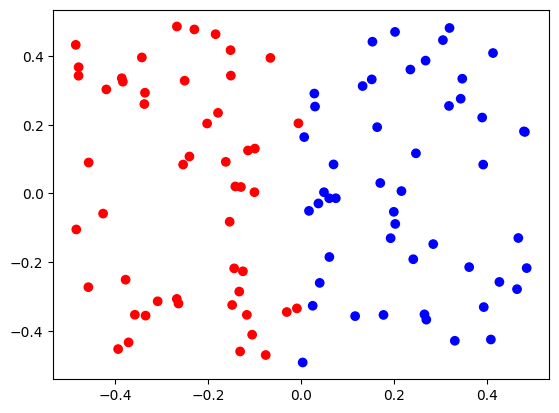

In [32]:
import numpy
from matplotlib import pyplot as plt

point_count = 50

X_B = abs(numpy.random.rand(point_count) - 0.5)
Y_B = numpy.random.rand(point_count) - 0.5

X_R = - abs(numpy.random.rand(point_count) - 0.5)
Y_R = numpy.random.rand(point_count) - 0.5

X_ = numpy.concatenate([X_B, X_R])
Y_ = numpy.concatenate([Y_B, Y_R])
Z_ = numpy.concatenate([numpy.repeat('b', point_count), numpy.repeat('r', point_count)])

plt.scatter(X_, Y_, color=Z_)
plt.show()

**2**

In [33]:
def rotate_matrix(X, angle=numpy.pi / 4):
    rotation_matrix = numpy.array(
        [[numpy.cos(angle), -numpy.sin(angle)], [numpy.sin(angle), numpy.cos(angle)]]
    )
    return X.dot(rotation_matrix)

**3**

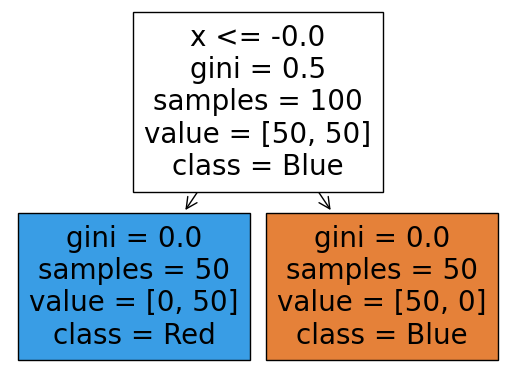

In [34]:
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dot_data = pandas.DataFrame()
dot_data['X'] = X_
dot_data['Y'] = Y_
dot_data['color'] = Z_

dt_model = DecisionTreeClassifier()
dt_model.fit(dot_data.drop(['color'], axis=1), dot_data['color'])

tree.plot_tree(dt_model, feature_names=['x', 'y'], class_names=['Blue', 'Red'], filled=True)
plt.show()

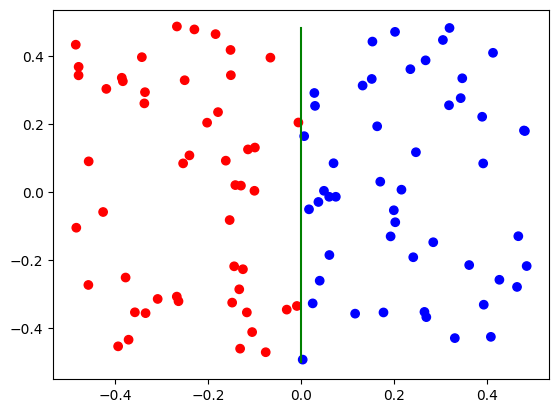

In [35]:
plt.scatter(X_, Y_, color=Z_)
classification_y = numpy.arange(-0.5, 0.5, 1. / 50)
classification_x = numpy.repeat(dt_model.tree_.threshold[0], len(classification_y))
plt.plot(classification_x, classification_y, color='g')

plt.show()

## How to survive spam and titanic incident

In [36]:
# You may want to install "gprof2dot"
import io
import pydot
import scipy.io
import sklearn.tree
from scipy import stats
from numpy import genfromtxt
import sklearn.model_selection
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

eps = 1e-5  # a small number


class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function *****
        labels = set(y)
        left = y[X < thresh]
        right = y[X >= thresh]
        entropy = 0.0
        for label in labels:
            if numpy.count_nonzero(y == label) > 0:
                entropy -= numpy.count_nonzero(y == label) * numpy.log2(numpy.count_nonzero(y == label) / len(y))
                if numpy.count_nonzero(left == label) > 0:
                    entropy += numpy.count_nonzero(left == label) * numpy.log2(
                        numpy.count_nonzero(left == label) / len(left))
                if numpy.count_nonzero(right == label) > 0:
                    entropy += numpy.count_nonzero(right == label) * numpy.log2(
                        numpy.count_nonzero(right == label) / len(right))
        return entropy / len(y)

    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO: implement gini impurity function *****
        labels = set(y)
        left = y[X < thresh]
        right = y[X >= thresh]
        gini = len(left) + len(right)
        for label in labels:
            gini -= numpy.count_nonzero(left == label) ** 2 / len(left)
            gini -= numpy.count_nonzero(right == label) ** 2 / len(right)
        return -(gini / len(y))

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = numpy.where(X[:, idx] < thresh)[0]
        idx1 = numpy.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = numpy.array([
                numpy.linspace(numpy.min(X[:, i]) + eps, numpy.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = numpy.nan_to_num(numpy.array(gains))
            self.split_idx, thresh_idx = numpy.unravel_index(numpy.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * numpy.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = numpy.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO: implement function *****
        for i in range(self.n):
            idx = numpy.random.choice(len(y), len(y), replace=True)
            x_rand = X[idx]
            y_rand = y[idx]
            self.decision_trees[i].fit(x_rand, y_rand)
        return self

    def predict(self, X):
        # TODO: implement function *****
        prediction = []
        for i in range(self.n):
            prediction.append(self.decision_trees[i].predict(X))
        prediction = numpy.vstack(prediction)
        return numpy.round(numpy.mean(prediction, axis=0))


class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1):
        # TODO: implement function *****
        if params is None:
            params = {'max_features': m}
        else:
            params['max_features'] = m
        super().__init__(params, n)


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = numpy.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = numpy.zeros(self.n)  # Weights on decision trees
        # TODO: implement function *****
        for j in range(self.n):
            idx = numpy.random.choice(len(y), len(y), replace=True, p=self.w)
            x_rand = X[idx]
            y_rand = y[idx]
            self.decision_trees[j].fit(x_rand, y_rand)
            yhat = self.decision_trees[j].predict(X)
            pred = numpy.array(y != yhat, dtype=float)
            ej = sum(self.w * pred) / sum(self.w)
            self.a[j] = 1 / 2 * numpy.log((1 - ej) / ej)
            self.w[pred == 1] *= numpy.exp(self.a[j])
            self.w[pred != 1] *= numpy.exp(-self.a[j])
            self.w /= sum(self.w)
        return self

    def predict(self, X):
        # TODO: implement function *****
        prediction = []
        y = []
        for j in range(self.n):
            y.append(self.decision_trees[j].predict(X))
        y = numpy.vstack(y)
        for i in range(X.shape[0]):
            labels = set(y[:, i])
            scores = []
            for label in labels:
                scores.append(self.a.dot(y[:, i] == label))
            prediction.append(y[numpy.argmax(scores, axis=0), i])
        return prediction


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = numpy.array(onehot_encoding).T
    data = numpy.hstack([numpy.array(data, dtype=float), numpy.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(0, data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) + (data[:, i] > -1 + eps))][:, i])[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)


dataset = "titanic"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100

if dataset == "titanic":
    # Load titanic data
    path_train = 'data/titanic/titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
    path_test = 'data/titanic/titanic_test_data.csv'
    test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
    y = data[1:, -1]  # label = survived
    class_names = ["Died", "Survived"]
    labeled_idx = numpy.where(y != '')[0]

    y = numpy.array(y[labeled_idx])
    y = y.astype(float).astype(int)

    print("\n\nPart (b): preprocessing the titanic data")
    X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z.shape[1]
    features = list(data[0, :-1]) + onehot_features

elif dataset == "spam":
    features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
    ]
    assert len(features) == 32

    # Load spam data
    path_train = 'data/spam/spam_data.mat'
    data = scipy.io.loadmat(path_train)
    X = data['training_data']
    y = numpy.squeeze(data['training_labels'])
    Z = data['test_data']
    class_names = ["Ham", "Spam"]

else:
    raise NotImplementedError("Dataset %s not handled" % dataset)

print("Features:", features)
print("Train/test size:", X.shape, Z.shape)

print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - numpy.sum(y) / y.size)

# Basic decision tree
print("\n\nPart (a-b): simplified decision tree")
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(X, y)
print("Predictions", dt.predict(Z)[:100])

print("\n\nPart (c): sklearn's decision tree")
clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf)
out = io.StringIO()

# You may want to install "gprof2dot"
sklearn.tree.export_graphviz(
    clf, out_file=out, feature_names=features, class_names=class_names)
graph = pydot.graph_from_dot_data(out.getvalue())
pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

# TODO: implement and evaluate!



Part (b): preprocessing the titanic data
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'male', 'female', 'S', 'C', 'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6166166166166166


Part (a-b): simplified decision tree


IndexError: invalid index to scalar variable.